In [87]:
# JRA55等圧面データ(netCDF形式)から、等渦位面天気図を作成する
import datetime
from dateutil import tz
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.interpolate as minterpolate
from metpy.units import units
#
import numpy as np
import xarray as xr

In [88]:
## 読み込みデータの指定
# JRA55の読み込む年月日時をUTCで与えます。
i_year =2010
i_month = 5
i_day = 7
i_hourZ = 0
# PV面を指定  1PV = 1.0 * 1E-6
f_pv = 1.5
const_pv = f_pv * 1E-6
# データ切り出し領域
lat_cut=slice(80.0,-20.0)
lon_cut=slice(70.0,190.0)
#
# データ格納先フォルダー名
# !!!　　UGRD_yyyymm.nc  などの保存先
DataFd="./data/Jra55/"
#
## 描画指定
# 地図の描画範囲指定
i_area = [115, 151, 20, 50]  # 日本付近
# 緯線・経線の指定
dlon,dlat=10,10   # 10度ごとに
## 気圧　等値線
levels_pre =np.arange(0,700,10)
## ISOTAC 等値線
levels_ws =np.arange(40,300,20)

In [89]:
## データ読み込み、データセット作成
# time番号                                                                 
time_targ=(i_day - 1) * 4 + i_hourZ // 6
# File名の一部文字列 年月                                     
yyyymm='{:04d}{:02d}'.format(i_year,i_month)
#
## 月別のNetCDF File名
# 風速:東西成分
UgrdFn ='{}UGRD_{}.nc'.format(DataFd,yyyymm)
# 風速:南北成分
VgrdFn ='{}VGRD_{}.nc'.format(DataFd,yyyymm)
# 高度
HgtFn ='{}HGT_{}.nc'.format(DataFd,yyyymm)
# 気温
TmpFn = '{}TMP_{}.nc'.format(DataFd,yyyymm)
#
## Wind U                                                                  
ds = xr.open_dataset(UgrdFn)
dataUgrd = ds.metpy.parse_cf('UGRD').squeeze()
dataUgrd.attrs['units'] = 'm/s'                                             
dataUgrd = dataUgrd.isel(time=time_targ)
dataUgrd = dataUgrd.sel(lat=lat_cut,lon=lon_cut)
## Wind V                                                                  
ds = xr.open_dataset(VgrdFn)
dataVgrd = ds.metpy.parse_cf('VGRD').squeeze()
dataVgrd.attrs['units'] = 'm/s'
dataVgrd = dataVgrd.isel(time=time_targ)
dataVgrd = dataVgrd.sel(lat=lat_cut,lon=lon_cut)
## 高度                                                                    
ds = xr.open_dataset(HgtFn)
dataHgt = ds.metpy.parse_cf('HGT').squeeze()
dataHgt.attrs['units'] = 'meter'
dataHgt = dataHgt.isel(time=time_targ)
dataHgt = dataHgt.sel(lat=lat_cut,lon=lon_cut)
## 気温                                                                    
ds = xr.open_dataset(TmpFn)
dataTmp= ds.metpy.parse_cf('TMP').squeeze()
dataTmp.attrs['units'] = 'K'                                              
dataTmp = dataTmp.isel(time=time_targ)
dataTmp= dataTmp.sel(lat=lat_cut,lon=lon_cut)

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [90]:
# 等渦位面の気圧を求めるために、気圧の3次元データ作成
cube_pre = np.zeros(dataHgt.values.shape)
for i in range(len(dataHgt['level'].values)):
    cube_pre[i,:,:] = dataHgt['level'].values[i]
#
### Dataset作成                                                                                                                            
ds = xr.Dataset(
  {
    "Geopotential_height_isobaric": (["level", "lat", "lon"], dataHgt.values),
    "u-component_of_wind_isobaric": (["level", "lat", "lon"], dataUgrd.values),
    "v-component_of_wind_isobaric": (["level", "lat", "lon"], dataVgrd.values),
    "Temperature_isobaric": (["level", "lat", "lon"], dataTmp.values),
    "Pressure": (["level", "lat", "lon"], cube_pre)
    # 'Pressure': (("level", "lat", "lon"), cube_pre * units.hPa)  #このような記述も可能
  },
  coords={
    "time": dataHgt["time"].values,
    "level": dataHgt["level"].values,
    "lat": dataHgt["lat"].values,
    "lon": dataHgt["lon"].values
    #  'lon': ('lon', dataHgt['lon'].values, {'units': 'degrees_east'})  #このような記述も可能
  }
)
## 単位設定                                                                      
ds['Geopotential_height_isobaric'].attrs['units'] = 'meter'
ds['u-component_of_wind_isobaric'].attrs['units'] = 'm/s'
ds['v-component_of_wind_isobaric'].attrs['units'] = 'm/s'
ds['Temperature_isobaric'].attrs['units'] = 'K'
ds['Pressure'].attrs['units'] = 'hPa'
#ds['time'].attrs['units'] = ''                                                  
ds['level'].attrs['units'] = 'hPa'
ds['lat'].attrs['units'] = 'degrees_north'
ds['lon'].attrs['units'] = 'degrees_east'

In [91]:
### 計算
# 温位
ds['PT'] = mpcalc.potential_temperature(ds['level'],ds['Temperature_isobaric'])
# 渦位
ds['PV'] = mpcalc.potential_vorticity_baroclinic(ds['PT'],ds['level'],
                                                 ds['u-component_of_wind_isobaric'],
                                                 ds['v-component_of_wind_isobaric'])
#
### 等渦位面データの作成
# 気圧
Pr_dt = minterpolate.interpolate_to_isosurface(ds['PV'].values,ds['Pressure'].values,const_pv)
# 温位
PT_dt = minterpolate.interpolate_to_isosurface(ds['PV'].values,ds['PT'].values,const_pv)
# 風
U_dt = minterpolate.interpolate_to_isosurface(ds['PV'].values,
                                              ds['u-component_of_wind_isobaric'].values,const_pv)
V_dt = minterpolate.interpolate_to_isosurface(ds['PV'].values,
                                              ds['v-component_of_wind_isobaric'].values,const_pv)
#
## Data Set of Dynamic Tropapause
dsDT = xr.Dataset(
  {
    "u-component_of_wind": (["lat", "lon"], U_dt),
    "v-component_of_wind": (["lat", "lon"], V_dt),
    "PotentialTemperature": (["lat", "lon"], PT_dt),
    "Pressure": (["lat", "lon"], Pr_dt),
  },
  coords={
    "time": dataHgt["time"].values,
    "level": const_pv,
    "lat": dataHgt["lat"].values,
    "lon": dataHgt["lon"].values,
  },
)
## 単位設定                                                                      
dsDT['u-component_of_wind'].attrs['units'] = 'm/s'
dsDT['v-component_of_wind'].attrs['units'] = 'm/s'
dsDT['PotentialTemperature'].attrs['units'] = 'K'
dsDT['Pressure'].attrs['units'] = 'hPa'
dsDT['level'].attrs['units'] = 'kelvin * meter ** 2 / kilogram / second'
dsDT['lat'].attrs['units'] = 'degrees_north'
dsDT['lon'].attrs['units'] = 'degrees_east'
#
## knotsへ変換
dsDT['u-component_of_wind'] = (dsDT['u-component_of_wind']).metpy.convert_units('knots')
dsDT['v-component_of_wind'] = (dsDT['v-component_of_wind']).metpy.convert_units('knots')
dsDT['wind_speed'] = mpcalc.wind_speed(dsDT['u-component_of_wind'], dsDT['v-component_of_wind'])

In [92]:
## 時刻文字列化                                                            
UTC = tz.gettz("UTC")
dt1 = datetime.datetime.fromtimestamp(dataHgt.time.astype(datetime.datetime) * 1e-9, tz=UTC)
dt_str = (dt1.strftime("%HZ%d%b%Y")).upper()
dt_str2 = dt1.strftime("%Y%m%d%H")
#print(dt_str)
#print(dt_str2)

/var/folders/sg/7nc0dtk94334h_fcm2j1glym0000gn/T/ipykernel_23484/4246721914.py:3: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dt1 = datetime.datetime.fromtimestamp(dataHgt.time.astype(datetime.datetime) * 1e-9, tz=UTC)


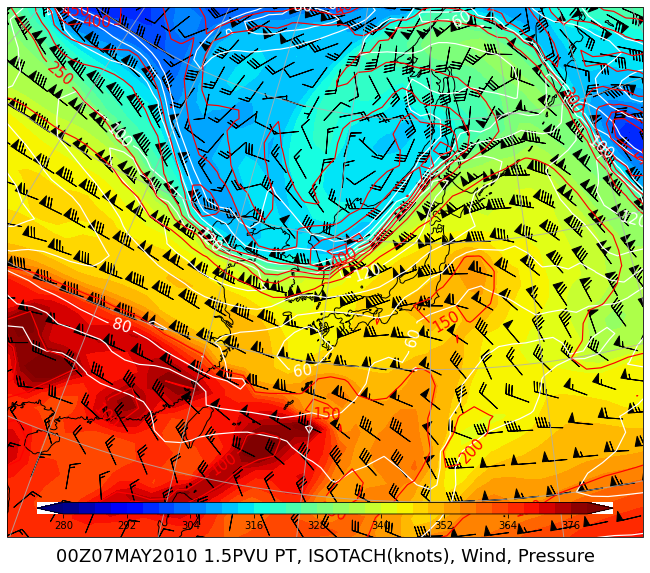

In [93]:
## 図のSIZE指定inch                                                              
fig = plt.figure(figsize=(10,8))                                          
## 余白設定                                                                      
plt.subplots_adjust(left=0, right=1, bottom=0.06, top=0.98)
## 図法指定
proj = ccrs.Stereographic(central_latitude=60, central_longitude=140)
latlon_proj = ccrs.PlateCarree() # 緯度経度の処理用に正距円筒図法も使う          
# 
## 図に関する設定                                                                
plt.rcParams["contour.negative_linestyle"] = 'solid'
## 余白  FAX図に合わせる                                                         
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent([108, 156, 17, 55], latlon_proj)
#
## 温位
cnf_pt = ax.contourf(dsDT['lon'], dsDT['lat'], dsDT['PotentialTemperature'],
                    np.arange(280,380,3), cmap="jet", extend='both',
                    transform=latlon_proj)
ax_pt = fig.add_axes([0.1, 0.1, 0.8, 0.02])
cb_pt = fig.colorbar(cnf_pt, orientation='horizontal', shrink=0.74,
                      aspect=40, pad=0.01, cax=ax_pt)
#
## 風速　 矢羽:データを間引いて描画                                                  
wind_slice2 = (slice(None, None, 2), slice(None, None, 2))
wind_slice0 = slice(None, None, 2)
ax.barbs(dsDT['lon'][wind_slice0], dsDT['lat'][wind_slice0],                              
         dsDT['u-component_of_wind'].values[wind_slice2],
         dsDT['v-component_of_wind'].values[wind_slice2],
         length=7.0,            
         pivot='middle', color='black', transform=latlon_proj)  
#
## ISOTAC                                                                        
cn_ws = ax.contour(dsDT['lon'], dsDT['lat'], dsDT['wind_speed'],
                   colors='white', alpha=1.0,
                   linewidths=1.2, levels=levels_ws, transform=latlon_proj )
ax.clabel(cn_ws, fontsize=15, inline=True, inline_spacing=5, fmt='%i', rightside_up=True)
#
## 気圧
cn_pre = ax.contour(dsDT['lon'], dsDT['lat'], dsDT['Pressure'],
                    colors='red',
                    linewidths=1.2, levels=np.arange(100,1000,50), transform=latlon_proj )
ax.clabel(cn_pre, fontsize=15, inline=True, inline_spacing=5,
          fmt='%i', rightside_up=True)
## 海岸線など
ax.coastlines(resolution='50m',) # 海岸線の解像度を上げる
# グリッド線を引く                                                               
dlon,dlat=10,10
xticks=np.arange(0,360.1,dlon)
yticks=np.arange(-90,90.1,dlat)
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)
gl.ylocator = mticker.FixedLocator(yticks)
#                         
# 図の説明
fig.text(0.5,0.01,dt_str+" {0}PVU PT, ISOTACH(knots), Wind, Pressure".format(f_pv),
         ha='center',va='bottom', size=18)
#
plt.show()